In [1]:
import gym
import numpy as np
import math
from itertools import product
from collections import defaultdict
from typing import *
from IPython.core.debugger import set_trace

import matplotlib.pyplot as plt

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Blackjack

Consider the game of Blackjack between the dealer and player. The goal of is to obtain a score-- computed as the sum of the values of the cards you have drawn from the deck- to be as near as possible to 21 without going over. Cards equal or less than 10 are worth their value but above 10, e.g. Jack, Queen and King are worth 10 with the exception of Ace which can either worth 11 or 1. The game starts with two cards revealed for the player and one card revealed for the dealer (drawn with replacement!). The player then has two options: (i) either `STICK` (they stops drawing additional cards) corresponding to value 0 or `HIT` (they request to draw an additional card) corresponding to value 1. The rules of the game are as follows:
- If the player decides to `STICK` and the sum of its cards is over 21
 they loses the game. 
- If the player stops with a score below or equal to 21
, the dealer starts to draw cards until its sum is greater or equal to 17.
- The person whose score is the nearest to 21
 without being above, wins the game. If both the player and the dealer have the same score or if both have a score strictly greater than 21, we call it a draw.

We use the Blackjack `gym` environment which encapsulates the rules of the Blackjack game with a few modifications.


In order to better understand the code, variable types are provided. In the following we define how `State`, `Action`, `Reward`, and `Count` variables are stored. For instance, `State` is always a tuple of size 3 where the first element represents the player's current hand sum. 

In [2]:
StateType = Tuple[int, int, bool] # (player's hand sum, dealer's revealed card, player's ace indicator)
ActionType = int
RewardType = float
CountType = int

In [3]:
blackjack = gym.make('Blackjack-v1')

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


This object will be a subclass of `gym.Env` and has two essential methods which we are going to use:
- `blackjack.step(action)` provides a way to interact with the game and play a certain action. 
- `blackjack.reset(seed)` provides a way to replay the game. 

In [4]:
blackjack.reset(seed=123)
state, reward, terminate, _ = out = blackjack.step(1)
print(out)
print(blackjack.dealer)

((12, 1, False), 0.0, False, {})
[1, 9]


The output of ```blackjack.step(1) = ((12, 1, False), 0.0, False, False, {})``` is summarized as such:


*   The first element $(12, 1, \text{False})$ in the tuple above represents a `StateType` tuple consisting of the sum of your hand $(12)$, the dealer's face up card $1$, i.e. an $\text{Ace}$, and whether you have an $\text{Ace}$ in your hand. 
*   The second element $0.0$ in the tuple above represents your (stochastic) reward for this immediate action.
*   The third element $\text{False}$ in the tuple above represents the terminate signal and indicates whether this hand has finished or not.
*   The fourth element $\{\}$ is irrelevant and can be ignored.


The output of ```blackjack.dealer=[1,9]``` is a list where the first element is the dealer's face up card $1$ and the other element(s) $9$ are the rest of their cards. 

We denote the state space as $\mathcal{S}$ and action space as $\mathcal{A}$. Based on the arguments above we have $|\mathcal{S}| = 640$ and $|\mathcal{A}| = 2$. Moreover, we represent the last state as the `TERMINAL` state.

In [5]:
n_actions = 2 # Total number of actions (Hit or Stick)
n_states = 32 * 10 * 2 # Total number of states (Your hand sum * Dealer Face Up * Your action)
TERMINAL = (33, 10, True) # Terminal state

**Goal:** For the game of blackjack we want to estimate the state value function $V: \mathcal{S} \to \mathbb{R}$ and optimal strategy $\pi : \mathcal{S} \to \mathcal{A}$ using:
- Value iteration method.
- Monte carlo with exploring starts

In either of the methods we assume the environment is **unknown** to the player, i.e. the average reward and transition probabilities for a certain state and action is not known. The player must explore the game and estimate these quantities empirically. To do so, an `Agent` which employs a certain strategy interacts with the blackjack environment and provides actions for a given state.


In [6]:
class Strategy(object):
  # Agent that plays randomly
  def __init__(self, n_actions: int):
    self.n_actions = n_actions
    self.pi : Dict[StateType, ActionType] = dict() # Holds the best possible action given a state
  
  def __call__(self, *args: Any, **kwds: Any) -> int:
    # This function allows you to produce an action by calling your strategy.
    return np.random.choice(range(self.n_actions))

  def assign(self, state:StateType, best_action: int):
    self.pi[state] = best_action
     

class HardExploreStrategy(Strategy):
  # Agent that plays greedily for states that has been previously observed.
  def __init__(self, n_actions: int):
    super().__init__(n_actions)
    self.pi: Dict[StateType, ActionType] = dict() # Holds the best possible action given a state
  
  def __call__(self, state: StateType) -> int:
    if state in self.pi:
      return self.pi[state]
    else:
      return super().__call__()
    
  def assign(self, state:StateType, best_action: int):
    super().assign(state, state, best_action)

class SoftExploreStrategy(Strategy):
  # Agent that plays epsilon-greedy for the observed states.
  def __init__(self, n_actions: int, exploration_rate: float = 0.1):
    super().__init__(n_actions)
    self.pi: Dict[StateType, ActionType] = dict() # Holds the best possible action given a state
    self.soft_pi : Dict[StateType, np.ndarray] = defaultdict(lambda: np.zeros(self.n_actions)) 
    self.eps = exploration_rate
  
  def __call__(self, state: StateType) -> int:
    if state in self.pi:
      return np.random.choice(range(self.n_actions), p=self.soft_pi[state])
    else:
      return super().__call__()

  def assign(self, state:StateType, best_action: int):
    super().assign(state, best_action)

    prob = self.soft_pi[state] = np.zeros(self.n_actions)
    prob += self.eps / self.n_actions
    prob[best_action] += 1 - self.eps 


In order to generate data we let our `Agent` to employ its strategy and interact with the game for many episodes (each episode indicate one game, from start untill termination).  

In [7]:
Trajectory = List[Tuple[StateType, ActionType, StateType, RewardType]]

def generate_episode_from_policy(env: gym.Env, pi: Strategy, seed: Optional[int] = None) -> Trajectory:
    state = env.reset(seed = seed)
    trajectory = []
    while True:
        action = pi(state) # Select your action at the current state.
        next_state, reward, terminate, _ = env.step(action)
        next_state = TERMINAL if terminate else next_state
        trajectory.append((state, action, next_state, reward)) # Receive your reward
        state = next_state # Transition (state, action) -> next_state
        if terminate:
            break
        
    return trajectory # [(state, action, next_state, reward)]

def monte_carlo(env: gym.Env, pi: Strategy, n_episodes: int) -> Iterator[Trajectory]: 

    env.reset(resetDict = True)
    for episode in range(n_episodes):
        trajectory = generate_episode_from_policy(env, pi)
        env.bookkeep(trajectory)
        yield trajectory

Now that we can generate our data using `monte_carlo` function we need to calculate the empirical transition probabilities $\hat{P}(s, a , s')$ and average reward $\hat{R}(s,a,s')$ for $s, s' \in \mathcal{S}$ and $a \in \mathcal{A}$. 

This is done by having a wrapper around the `blackjack` environment and book keeping the games that's been played. For instance, we can calculate the transition probability for $(s,a,s')$ using the number of times this trnasition occured divided by number of times state $s$ was visited followed by taking action $a$. 

In [8]:
StateActionType = Tuple[StateType, ActionType]

class BlackJack(gym.Wrapper):
  # A wrapper around the environment with bookkeeping. 

  def __init__(self, env: gym.Env):
    super(BlackJack, self).__init__(env)

    self.reset_dicts()
    

  def reset_dicts(self):
    # The following is the dict the takes the tuple (state, action) as input 
    # and gives the vector of transition probabilities.
    self.P: Dict[StateActionType, np.ndarray] = defaultdict(lambda: np.zeros(n_states)) # represents transition probabilities.
    self.count: Dict[StateActionType, np.ndarray] = defaultdict(lambda: np.zeros(n_states)) # represents counts.
    self.R: Dict[StateActionType, np.ndarray] = defaultdict(lambda: np.zeros(n_states)) # representes rewards.

  def reset(self, resetDict = False, **kwargs):
    if resetDict:
      self.reset_dicts()
    return super().reset()

  def bookkeep(self, trajectory: List[Trajectory]):
    
    for state, action, next_state, reward in trajectory:
          next_state_index = get_state_index(next_state)
          # Update the count for (s, a, s')
          self.count[(state, action)][next_state_index] += 1
          count = self.count[(state, action)][next_state_index]
          # Update the empirical expected reward R(s, a, s')
          r = self.R[(state, action)][next_state_index]
          self.R[(state, action)][next_state_index] = reward / count + r * (1 - 1/count)
          # Update the transition probabilies
          self.P[(state, action)] = self.count[(state, action)] / np.sum(self.count[(state,action)])
  
  
def get_state_index(state: StateType) -> int:
  # This function maps a state to an integer ranging from 0 to n_states-1
  return (state[0]-2) + 32 * ( (state[1] - 1) +  10 * state[2] )

def get_state_from_index(index : int) -> StateType:
  # The inverse function
  player_sum = (index % 32) + 2
  index = index // 32 
  dealer_card = (index % 10) + 1
  ace = bool(index // 10)
  return (player_sum, dealer_card, ace)

Now we are ready to generate a dataset. From now on we work with `bj` object instead of `blackjack`.

In [9]:
bj = BlackJack(blackjack)
pi = Strategy(n_actions) # Random action
n_episodes = 100000 # Set to 500000 for better perfomance
gamma = 0.9 # Discount factor

In [10]:
trajectories = list(monte_carlo(bj, pi, n_episodes)) # Generate data and book keep the results

We also need helper functions to plot the results. Please go through these functions and make sure you understand how they are plotting the state values and policies. 

In [11]:
def plot_state_values(V: np.ndarray, iterations): 
	x_range = np.arange(12, 22) # if < 12 we are not dumb and we pick another card
	y_range = np.arange(1, 11) # dealer's face up card 
	X, Y = np.meshgrid(x_range, y_range)

	fig = plt.figure(figsize=(15,20))

	aces = [(True, "Usable ace"), (False, "No usable ace")]

	for i, (usableAce, title) in enumerate(aces, 1):
		ax = fig.add_subplot(int("21" + str(i)), projection='3d')
		Z = np.array([V[get_state_index((x, y, usableAce))] for y in Y[:,0] for x in X[0] ]).reshape(X.shape) 

		surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
							   edgecolor='w', linewidth=0.5)
		ax.set_xlabel("Player's Current Sum")
		ax.set_ylabel("Dealer's Showing Card")
		ax.set_zlabel("Value")
		ax.view_init(ax.elev, -120)
		ax.set_title(title, fontsize=14)

	fig.suptitle("Value after %i iterations" % iterations, fontsize=20)
	plt.show()
 

def plot_policy(pi: Strategy, headline: str):

  def draw(pi, ax, aceValue):
      rows, cols = 10, 10
      image = np.zeros((rows, cols))

      for state, val in pi.pi.items():
          player_sum, dealer_card, usableAce = state
          if usableAce != aceValue or player_sum < 12 or player_sum > 21:
              continue

          image[player_sum-12, dealer_card-1] = 1-val

           
      row_labels = np.arange(12, 22)
      col_labels = ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10']
      surf = ax.matshow(image, cmap=plt.get_cmap('Pastel1', 2),
                        extent=[0, 10, 21, 11])
      plt.gca().invert_yaxis()
      plt.xticks(np.arange(0, 10, 1), col_labels)
      plt.yticks(np.arange(12, 22, 1), row_labels)
      ax.grid(color='white', linestyle='--', linewidth=1, which='major')
      ax.set_title("%s ace" % ("Usable" if aceValue else "No usable"),
                    fontsize=16)
      
      divider = make_axes_locatable(ax)
      cax = divider.append_axes("right", size="10%", pad=0.2)
      cbar = plt.colorbar(surf, ticks=[0.25,0.75], cax=cax, )
      cbar.ax.set_yticklabels(['HIT','STICK'])
      


  f = plt.figure(figsize=(15,8))

  aces = [(True, "Usable ace"), (False, "No usable ace")]

  for i, (usableAce, title) in enumerate(aces, 1):
      ax = f.add_subplot(int("12" + str(i)))
      draw(pi, ax, usableAce)
  
  f.suptitle(headline, fontsize=20)
  plt.show()

# **Value Iteration**

Markov decision processes (MDP) provide a framework for modeling decision making where outcomes are partly random but also partly under the control of the decision maker. Value iteration is a way to compute an optimal decision policy and its value. See the [reference](https://artint.info/html/ArtInt_227.html) for more information and summary of the algorithm:

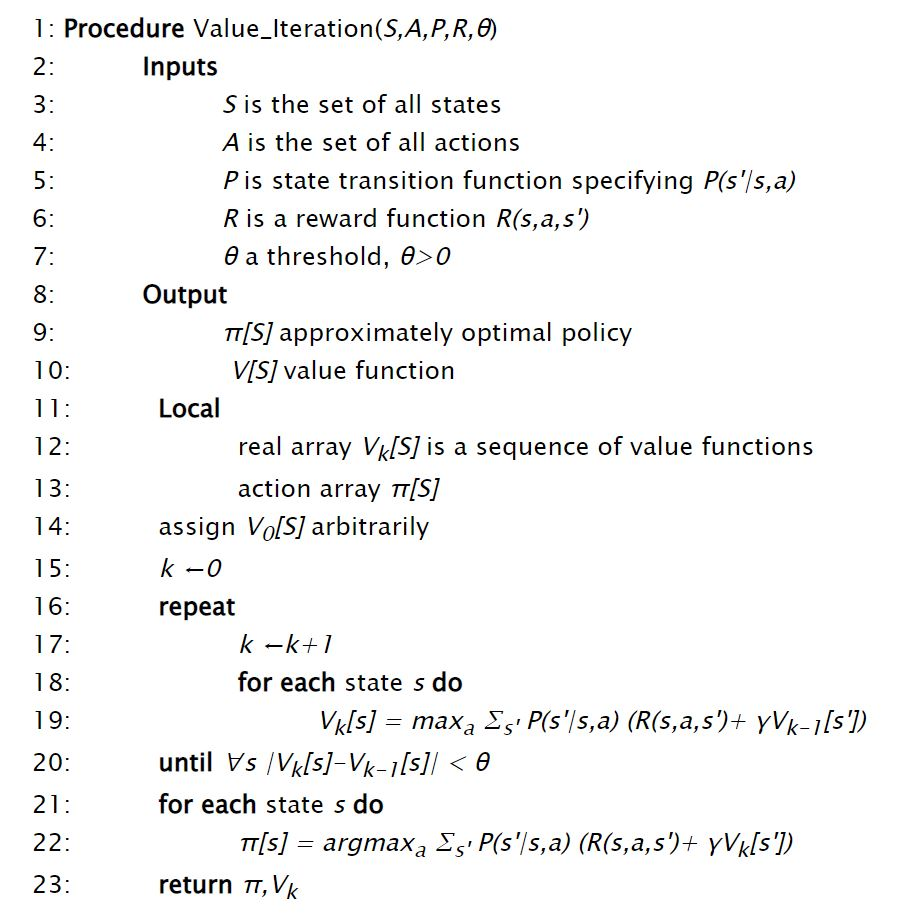

### **Question**:###
Implement the value iteration algorithm by filling in the rest of the lines below. Note that, at any given stage, you only have two possible actions which are to "hit" $(1)$ or to "stick" $(0)$.


1.   Complete the while loop in the ```valueIteration``` algorithm.

2.   Get the optimal policy $\pi$ from the ```valueIteration``` algorithm.

3.   Use ```plot_state_values``` to plot the value function $V$ and use ```plot_policy``` to plot the policy $\pi$.



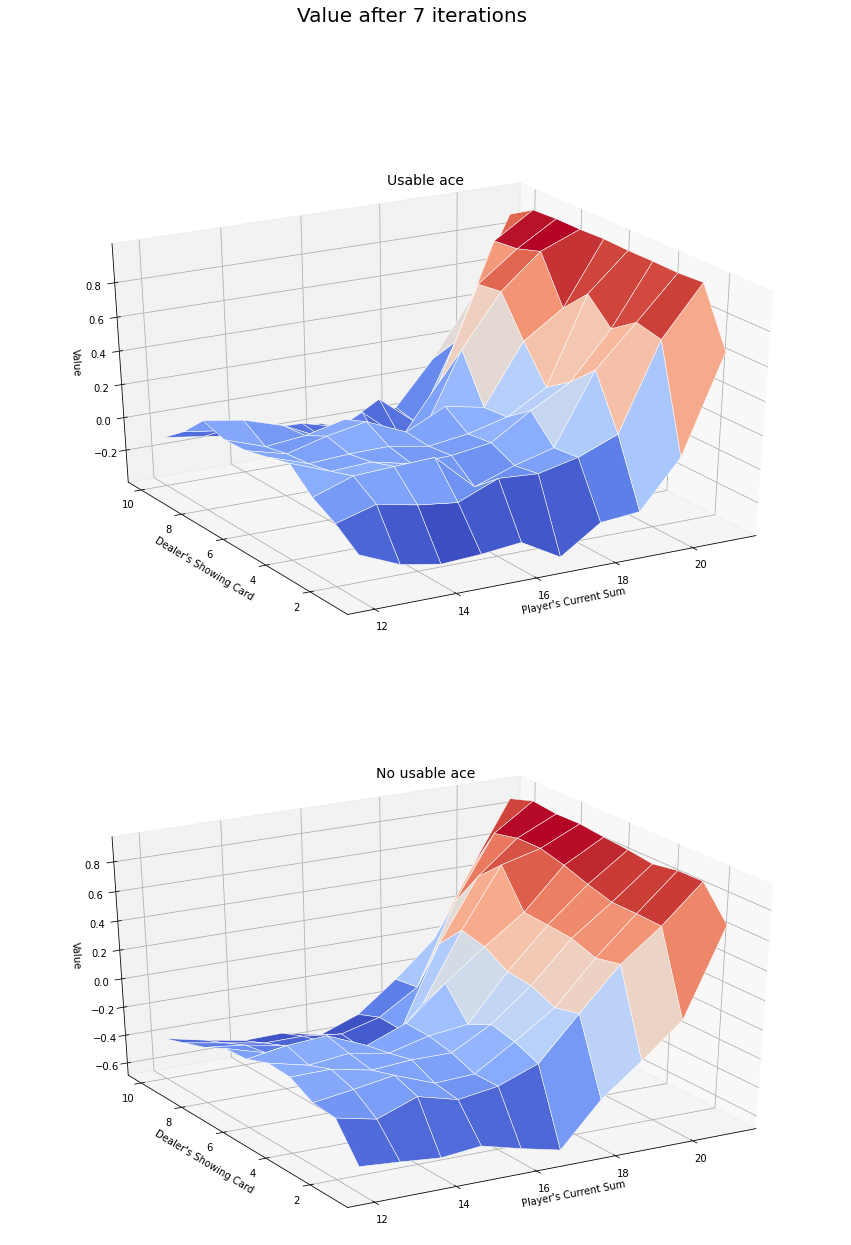

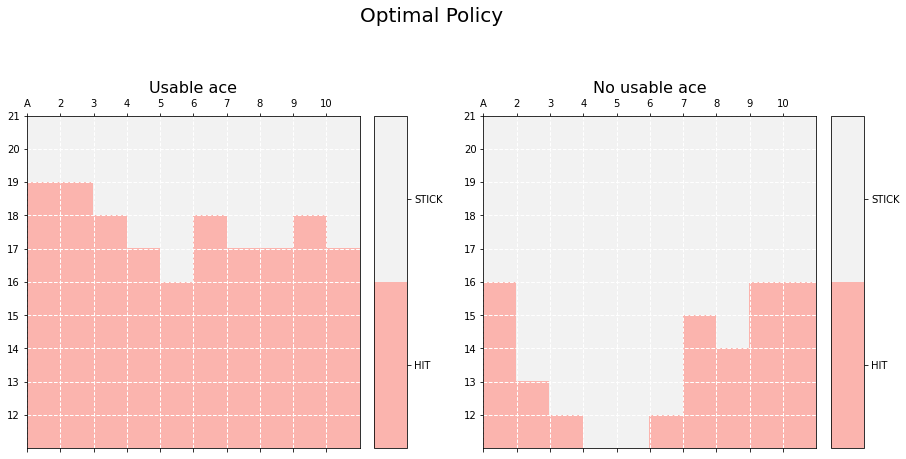

In [12]:
from pyparsing.unicode import pyparsing_unicode
from locale import PM_STR
def to_numpy(d: Dict[StateActionType, np.ndarray]) -> np.ndarray:
  # Converts a dictionary into a numpy array.
  # Note that d_numpy[i , a , :] corresponds to d[(state get_state_from_index(i), a)].
  d_numpy = np.zeros(shape = (n_states, n_actions, n_states))

  for (state, action), value in d.items():
    d_numpy[get_state_index(state), action, :] = value

  return d_numpy

v=np.zeros(n_states)
def valueIteration(P: Dict[StateActionType, np.ndarray], # Transition Probabilities 
                   R: Dict[StateActionType, np.ndarray], # Rewards
                   theta: float = 1e-3, # Tolerance Parameter
                   gamma: float = 0.5, # Reward Discount Parameter
                   ):
  
  V = np.zeros(n_states)
  P_numpy, R_numpy = to_numpy(P), to_numpy(R)
  optimal_pi : Dict[StateType, ActionType] = dict()
  converged = False

  while not converged:
    ### YOUR CODE HERE ###
    dif=0
    V_temp= np.array(list(V)[:])
    for t in range(n_states):
      p_t_a1= P_numpy[t,0,:]
      p_t_a2= P_numpy[t,1,:]
      r_t_a1= R_numpy[t,0,:]
      r_t_a2= R_numpy[t,1,:]
      V[t]= max(np.dot(p_t_a1,(r_t_a1+ gamma* V_temp)), np.dot(p_t_a2,(r_t_a2+ gamma* V_temp)))
      dif= max(dif, abs(V[t]-V_temp[t]))
    if dif<theta:
      converged=True
      for t in range(n_states):
        p_t_a1= P_numpy[t,0,:]
        p_t_a2= P_numpy[t,1,:]
        r_t_a1= R_numpy[t,0,:]
        r_t_a2= R_numpy[t,1,:]
        a_1= np.dot(p_t_a1,(r_t_a1+ gamma* V_temp)) > np.dot(p_t_a2,(r_t_a2+ gamma* V_temp))
        optimal_pi[t]= 0 if a_1 else 1

    yield V, optimal_pi, converged

iterator = enumerate(valueIteration(bj.P, bj.R, theta =1e-5, gamma = gamma))
for i, (V, optimal_pi, converged) in iterator:
  if converged:
    plot_state_values(V,i)
    pi=Strategy(2)
    for state_index, best_action in optimal_pi.items():
      pi.assign(get_state_from_index(state_index), best_action)
    plot_policy(pi,"Optimal Policy")
# Plots for V values and pi
### YOUR CODE HERE ###

### Comments on DP and Blackjack
"Although we have complete knowledge of the environment in the blackjack task, it would not be easy to apply DP (Dynamic Programming) methods to compute the value function. DP methods require the distribution of next events—in particular, they require the environments dynamics as given by the four-argument function p—and it is not easy to determine this for blackjack. For example, suppose the player’s sum is 14 and he chooses to stick.
What is his probability of terminating with a reward of +1 as a function of the dealer’s showing card? All of the probabilities must be computed before DP can be applied, and such computations are often complex and error-prone. In contrast, generating the sample games required by Monte Carlo methods is easy. This is the case surprisingly often; the ability of Monte Carlo methods to work with sample episodes alone can be a significant advantage even when one has complete knowledge of the environment’s dynamics." - [Reinforcement Learning - An Introduction, Sutton and Barto, pg. 94](https://www.andrew.cmu.edu/course/10-703/textbook/BartoSutton.pdf)

### Monte Carlo with Exploring Starts (MCES)


*   $\pi$ - a policy
*   $Q(s,a)$ the average return from state $s$ taking action $a$


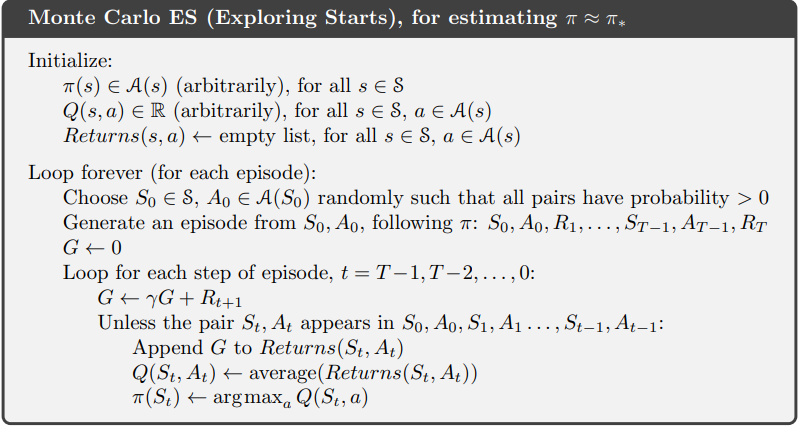

### **Question**

We will start off by setting an initial policy where we hit on everything.

Let us use the function ```generate_episode_from_policy``` to write the MCES algorithm.


1.   Fill in the necessary lines to complete the loop.
2.   Complete the first visit MC-MC.





In [13]:
def MCES(env, n_episodes, gamma):
    # initialize pi, Q(s,a), and returns
    pi : Strategy  = SoftExploreStrategy(n_actions)
    Q : Dict[StateType, np.ndarray] = defaultdict(lambda: np.zeros(n_actions))
    returns : Dict[StateType, Tuple[RewardType, CountType]] = dict()
    
    for episode in range(n_episodes):
        trajectory = generate_episode_from_policy(env, pi, seed=2*episode)
        G, T = 0, len(trajectory)
        
        states_visited = set()
        for i in range(T-1,-1,-1):
            ### YOUR CODE HERE ###
            state, action, next_state, reward = trajectory[i]
            G = gamma * G + reward
                        
            if (state, action) not in states_visited:
                ### YOUR CODE HERE ###
                if state not in returns:
                  returns[state]= (G,1)
                else:
                  returns[state]= (returns[state][0]+G, returns[state][1]+1)
                  
                
                Q[state][action]=returns[state][0]/returns[state][1]
                best_action= np.argmax(Q[state])
                pi.assign(state,best_action)
                                
                states_visited.add((state, action))
    
    return Q, pi

### **Question:**

1.   Transform the state-value function $Q$ to the value function $V$.
2.   Use ```plot_state_values``` to plot the value function $V$ and use ```plot_policy``` to plot the policy $\pi$ for ```n_episodes``` $\in \{10000, 50000, 100000\}$






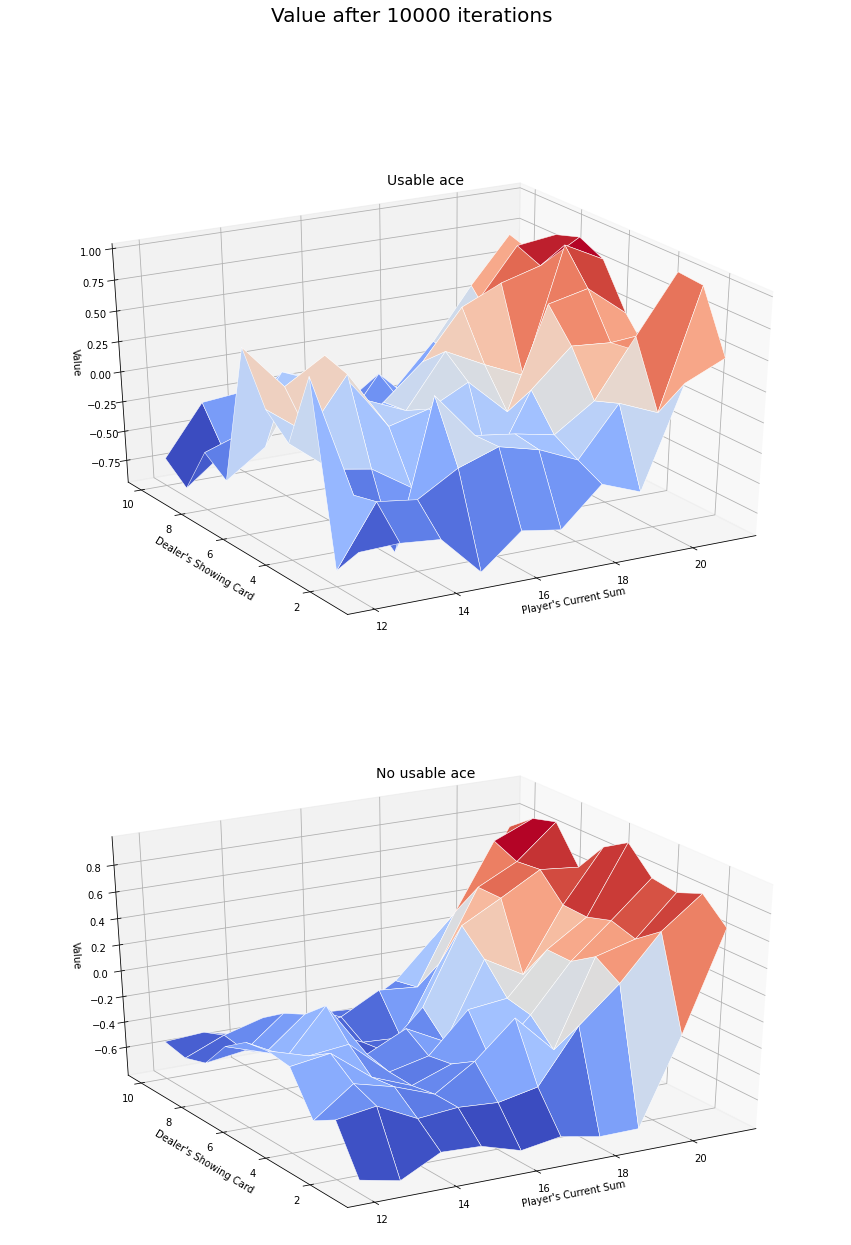

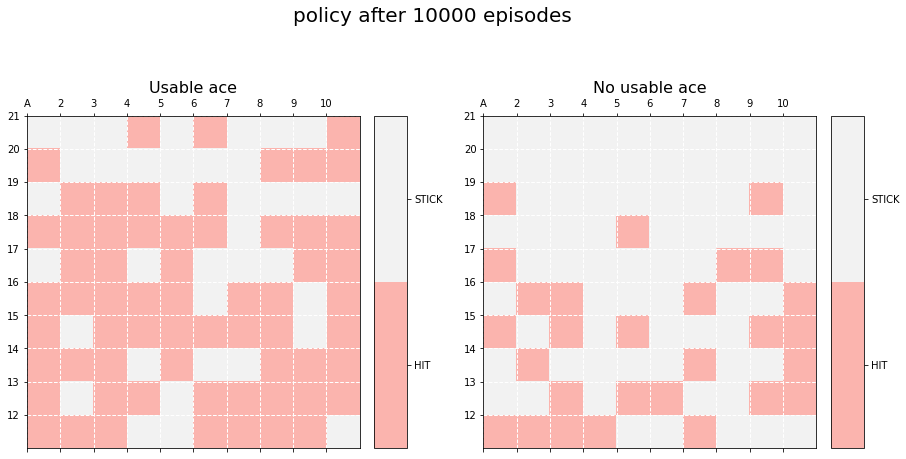

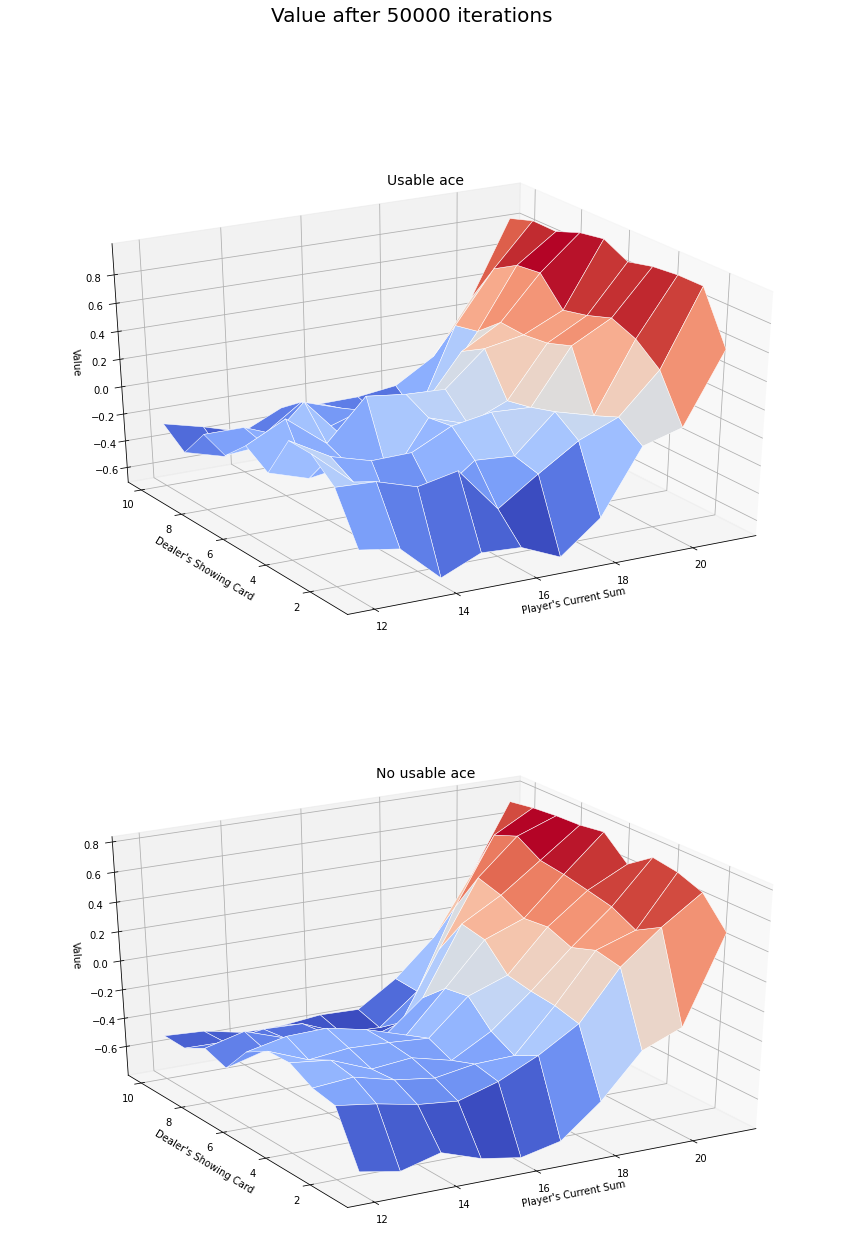

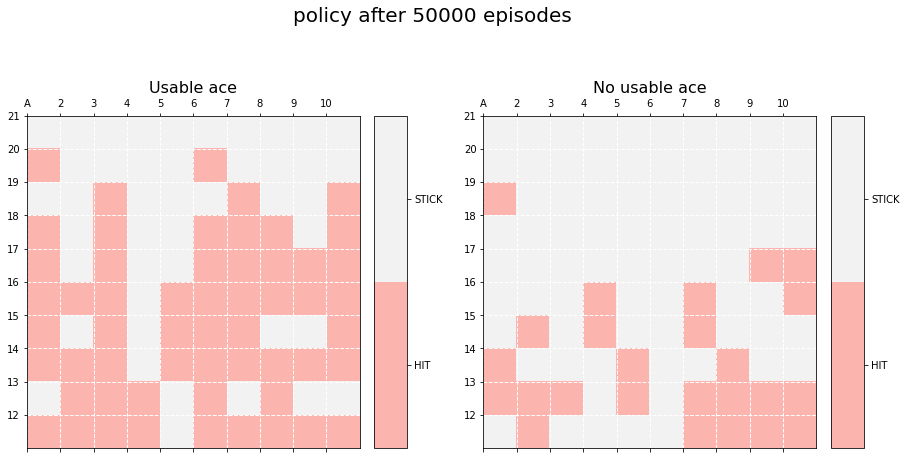

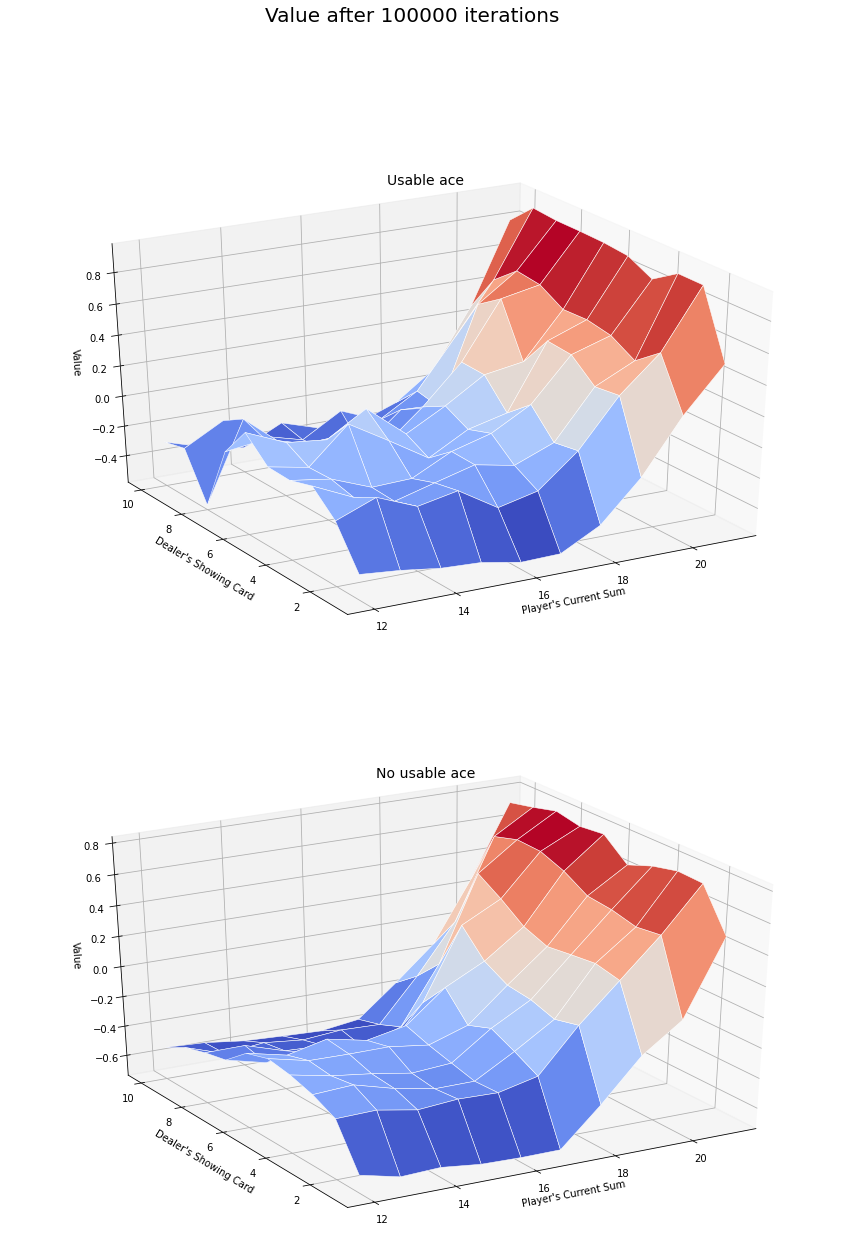

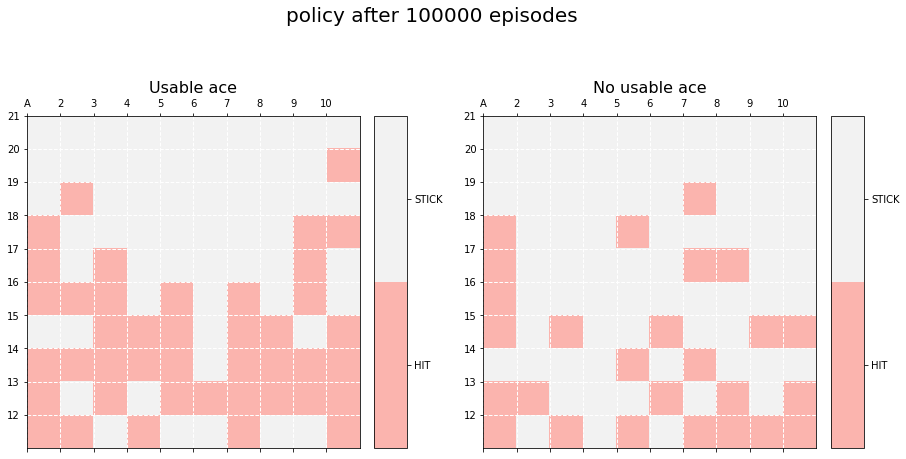

In [14]:
def transformQtoV(Q):
  ### YOUR CODE HERE ###
  V= np.zeros(n_states)
  for t in range(n_states):
    V[t]=max(Q[get_state_from_index(t)])
  return V


for n_episodes in [10000, 50000, 100000]:
  Q, pi = MCES(blackjack, n_episodes, gamma)
  ### YOUR CODE HERE ###
  V= transformQtoV(Q)
  plot_state_values(V, n_episodes)
  plot_policy(pi, "policy after "+str(n_episodes)+" episodes")

Let us compare our results to a typical Blackjack [strategy card,](https://www.amazon.com/Blackjack-Basic-Strategy-Chart-Dealer/dp/0982119151) which summarizes a somewhat optimal strategy for playing Blackjack. In the chart below, $\boldsymbol{D}$ and $\boldsymbol{DS}~$ are doubling down actions. $\boldsymbol{R}$ and $\boldsymbol{RS}~$ are surrendering actions (you think the dealer has Blackjack or something better than you and you can surrender for a partial ``refund''.) For our purposes, assume that both actions are equivalent to hitting (if you are already committed and think the dealer has a better hand than you, then you might as well try to do better). Note that if you have 18 or higher in the strategy card, you are sticking regardless. Hard totals imply that you don't have a usable Ace while soft totals imply that you do.

Note that the strategy card takes into consideration the nuances of the game, e.g. we have a finite number of decks (4/6/8) or there are other actions that we can take besides hitting and sticking.

### **Question:**

1.   Point out the differences between the MCES policy, the Value Iteration policy, and the strategy card and explain to what we could attribute these differences.
2.   Explain how we could potentially improve upon the MCES algorithm.



ANS:

1. Policy iteration includes policy evaluation and policy improvement, and the two are repeated iteratively until policy converges. In policy iteration algorithms, you start with a random policy, then find the value function of that policy (policy evaluation step), then find a new (improved) policy based on the previous value function, and so on. In this process, each policy is guaranteed to be a strict improvement over the previous one. In this case, with aces available, we don't always choose to hit as the value iteration strategy suggests when we have fewer than 18 cards in hand, and sometimes we may choose to stick. Also, we don't have an explicit threshold for no aces available. When our hand is less than 16, and the dealer's hand is less than 7 or greater than 7, sometimes we still choose to insist instead of choosing. For example, with no aces available, when our hand is between 13 and 15 and the dealer's hand is a 9, we choose to stick rather than hit, unlike the value iteration strategy. <br>
Value iteration includes finding the optimal value function and one policy extraction. There is no repeat of the two because once the value function is optimal, then the policy out of it should also be optimal (i.e. converged). In value iteration, you start with a random value function and then find a new (improved) value function in an iterative process, until reaching the optimal value function. In this case, when our total hand is less than 18 in terms of available aces, we should always hit regardless of what the dealer has. Otherwise we should choose to persist. For the situation where no ace is available, when our total hand is less than 16 and the dealer's hand is greater than 7 or less than 3, we should choose hit. Otherwise we should choose to persist.<br>
For MCES policy iteration, at each step, policy evaluation is run until convergence, then the policy is updated and the process repeats. In contrast, Value Iteration policy only does a single iteration of policy evaluation at each step. Then, for each state, it takes the maximum action value to be the estimated state value. Once these state values have converged, to the optimal state values, then the optimal policy can be obtained. In practice, it performs much better than the MCES policy iteration and finds the optimal state value function in much fewer steps.<br>
As shown in the strategy card, there is a clear threshold. In terms of available aces, we choose hit or double when our hand is less than 17, otherwise we choose stick. In terms of no usable ace, policy cards have different rules from MCES and Value Iteration Policy. When our hand is less than 12 and the dealer's hand is less than 7, we choose to bid. We also choose to bid when our hand is less than 17 and the dealer's hand is greater than 7. 

2. Monte Carlo Exploring Starts (MCES) algorithm, where the Q-function is estimated by averaging the Monte Carlo returns, is improved by choosing actions that maximize the current estimate of the Q-function. Exploration is performed by "exploring starts", which is, each episode begins with a randomly chosen state and action, and then follows the current policy to the terminal state. We can improve the MCES algorithm by improving the convergence of the algorithm using an optimal policy like delta-soft policy or more iteration times.

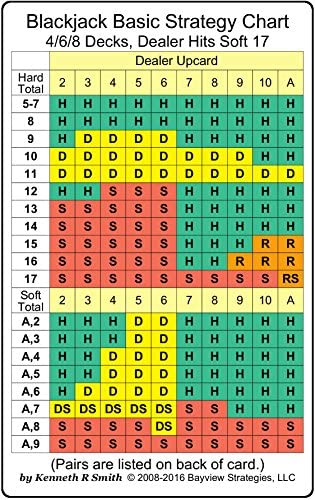